# MetaChat analysis on Visium HD data of mouse small intestine

In this tutorial, we use mouse small intestine as an example to show the basic application of MetaChat to visium HD datasets [[10x genomics](https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-mouse-intestine)].

In [1]:
# Importing packages
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Setting your work dictionary
os.chdir("/home/project/metachat_packages/")

In [3]:
import sys
sys.path.append("/home/project/metachat_packages/MetaChat-main/")
import metachat_new as mc

## Import dataset

Here, we directly provide the combined transcriptomics and metabolomics dataset that has been preprocessed for MetaChat.
For detailed instructions on how to infer metabolomic profiles from transcriptomic data using Compass, please refer to the tutorials section.

In [4]:
adata = sc.read('datasets/mouse_small_intestine/adata_combined_subset.h5ad')

The spatial distribution of clusters reveals well-defined anatomical layers and regions in the mouse small intestine.

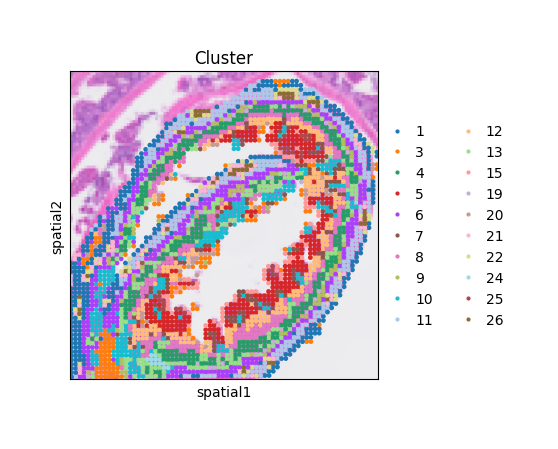

In [5]:
fig, ax = plt.subplots(figsize = (4,4))
sq.pl.spatial_scatter(adata = adata,
                      color = "Cluster",
                      ax = ax)
ax.set_box_aspect(1)

## MCC Inference

### Import MetaChatDB

Load the curated MetaChat database containing metabolite–sensor interaction pairs for mouse (or human).

In [6]:
df_metasen = mc.pp.MetaChatDB(species='mouse') # If human, please input species='human'.

### Identify long-range channels (LRCs)

In this example, we aim to identify blood vessels as potential LRC pathways.
To achieve this, we use a gene-marker–based approach to locate candidate points, leveraging the expression of known vascular markers to guide the identification of regions likely involved in long-range metabolite transport.

In [7]:
LRC_name = "Blood"
LRC_marker_genes = ["Myh11", "Mgp", "Cldn5"]

<Axes: title={'center': 'Cldn5'}, xlabel='spatial1', ylabel='spatial2'>

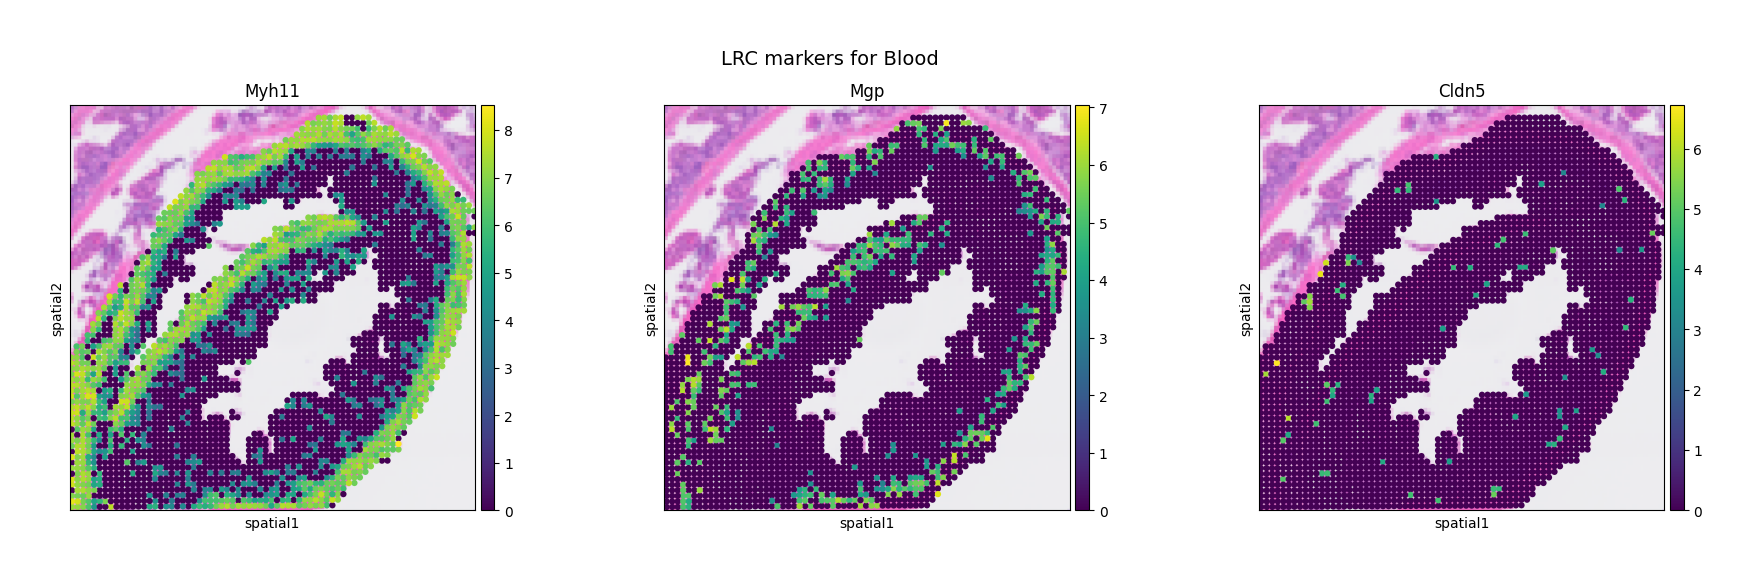

In [8]:
mc.pl.plot_LRC_markers(adata = adata,
                       LRC_name = LRC_name,
                       LRC_marker_genes = LRC_marker_genes,
                       avg = False,
                       figsize = (10, 5))

We can observe that these blood vessel markers show localized enrichment around the muscularis layer of the small intestine, suggesting that blood vessels in this region may represent potential LRCs.

<Axes: title={'center': 'LRC_Blood_avg_markers'}, xlabel='spatial1', ylabel='spatial2'>

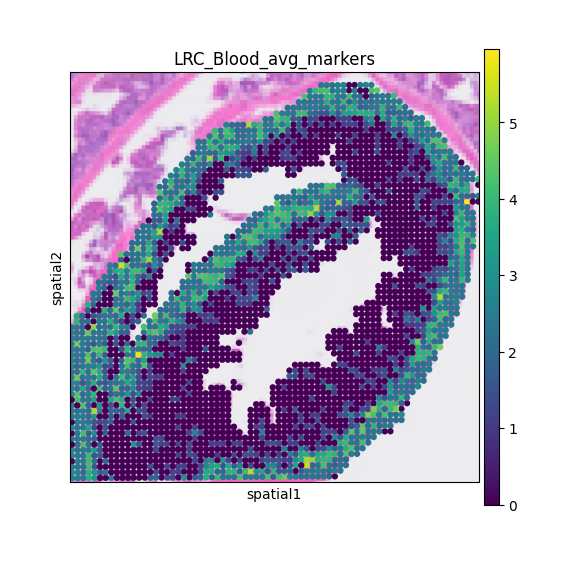

In [9]:
mc.pl.plot_LRC_markers(adata = adata,
                       LRC_name = LRC_name,
                       LRC_marker_genes = LRC_marker_genes,
                       avg = True,
                       figsize = (5, 5))

The `mc.pl.plot_LRC_markers` function can also visualize the average expression of multiple markers, providing a more robust signal for identifying potential LRC regions.

In [10]:
mc.pp.LRC_unfiltered(adata = adata,
                     LRC_name = LRC_name,
                     LRC_source = 'marker',
                     obs_name = 'LRC_' + LRC_name + '_avg_markers',
                     quantile = 60)

Cells above the 60% have been selected as candidates and stored in 'adata.obs['LRC_Blood_marker_unfiltered']'.


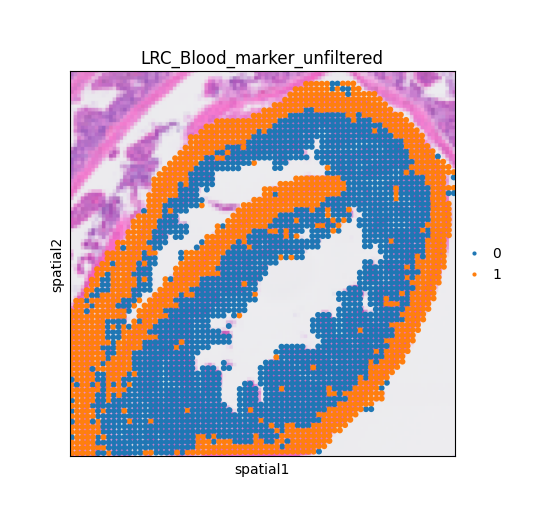

In [11]:
fig, ax = plt.subplots(figsize = (6,5))
sq.pl.spatial_scatter(adata,
                      color = 'LRC_Blood_marker_unfiltered',
                      ax = ax)
ax.set_box_aspect(1)

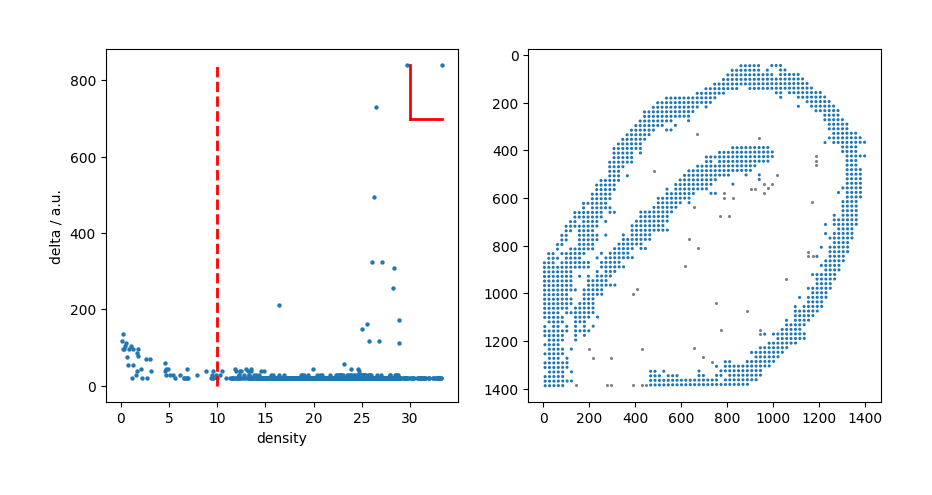

In [12]:
LRC_cluster_Blood = mc.pp.LRC_cluster(adata = adata,
                                    LRC_name = LRC_name,
                                    LRC_source = "marker",
                                    density_cutoff = 30,
                                    delta_cutoff = 700,
                                    outlier_cutoff = 10)

Then, the `mc.pp.LRC_filtered()` function was executed to remove outlier points from the clustered Blood LRC candidates, and the filtered LRCs were stored in adata.obs['LRC_Blood_marker_filtered'].

In [13]:
mc.pp.LRC_filtered(adata = adata,
                   LRC_name = LRC_name,
                   LRC_cluster = LRC_cluster_Blood,
                   LRC_source = "marker")

Candidate points for Blood LRC are clustered and outliers are removed. LRC points are stored in 'adata.obs['LRC_Blood_marker_filtered']'.


/home/project/metachat_packages/MetaChat-main/metachat_new/preprocessing/_identifyLRC.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[key_filtered][adata.obs[key_filtered] == 1] = newcluster


Then, we can visualize the determined LRC.

In [14]:
adata

AnnData object with n_obs × n_vars = 3264 × 19488
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region', 'Cluster', 'LRC_Blood_marker_Myh11', 'LRC_Blood_marker_Mgp', 'LRC_Blood_marker_Cldn5', 'LRC_Blood_avg_markers', 'LRC_Blood_marker_unfiltered', 'LRC_Blood_marker_filtered'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Cluster_colors', 'barrier_colors', 'in_tissue_colors', 'log1p', 'region_colors', 'spatial', 'spatialdata_attrs', 'LRC_Blood_marker_unfiltered_colors'
    obsm: 'spatial'

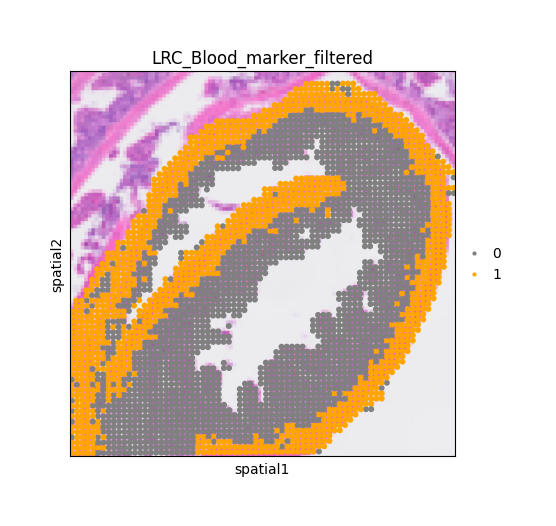

In [15]:
# Set color for LRCs
adata.obs['LRC_Blood_marker_filtered'] = adata.obs['LRC_Blood_marker_filtered'].astype('category')
adata.uns['LRC_Blood_marker_filtered' + '_colors'] = ['gray', 'orange']

fig, ax = plt.subplots(figsize = (6,5))
sq.pl.spatial_scatter(adata,
                      color = 'LRC_Blood_marker_filtered',
                      alpha = 1,
                      ax = ax)
ax.set_box_aspect(1)

### Import barrier condition

MetaChat provides a function `mc.pp.load_barrier_segments` to import this barrier information. The coordinate order in Napari may differ from that in Visium; you can define the order using `coord_cols`. The adata uses `tissue_hires_scalef` coordinates during import, while the images use `tissue_lowres_scalef`. Since we directly annotate barriers on the images, we should adjust the `scale` to align with the adata data.

In [16]:
dict_scale = adata.uns['spatial']['Visium_HD_Mouse_Small_Intestine_lowres_image']['scalefactors']
scale = dict_scale['tissue_hires_scalef']/dict_scale['tissue_lowres_scalef']
barrier_segs = mc.pp.load_barrier_segments("datasets/mouse_small_intestine/barrier.csv", coord_cols=("axis-2", "axis-1"), scale=scale)

We can use simple visualization to check whether the barrier coordinates are correct.

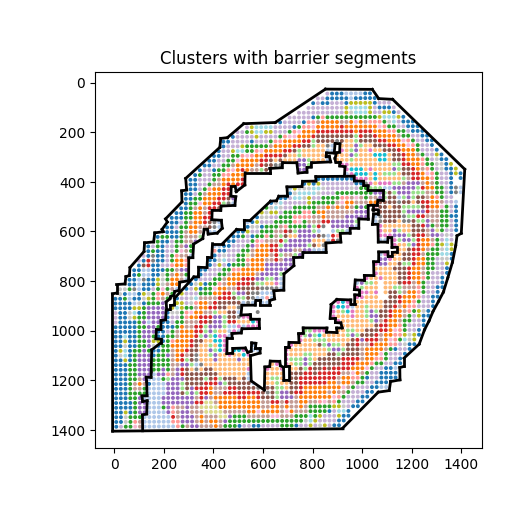

In [17]:
# Check barriers
clusters = adata.obs["Cluster"] if "Cluster" in adata.obs else None
XY = np.asarray(adata.obsm["spatial"], float)

fig, ax = plt.subplots(figsize=(5,5))
cats = pd.Categorical(clusters)
ax.scatter(XY[:,0], XY[:,1], s=8, c=cats.codes, cmap="tab20", edgecolor="none")

for (a, b) in barrier_segs:
    x = [a[0], b[0]]
    y = [a[1], b[1]]
    ax.plot(x, y, lw=2, c="black")

ax.set_aspect("equal", adjustable="box")
ax.invert_yaxis()
ax.set_title("Clusters with barrier segments")
plt.show()

In summary, we can visualize the identified long-range channels (LRCs) and barrier structures to better understand how anatomical boundaries and vascular pathways shape spatial metabolite communication.

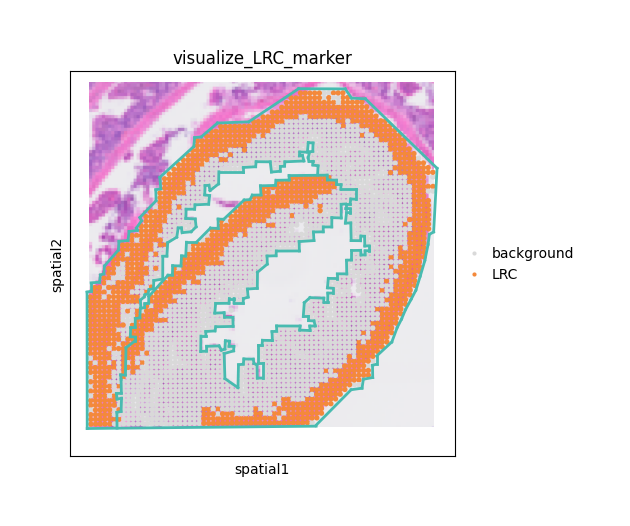

In [18]:
# Prepare color 
mrk = adata.obs['LRC_Blood_marker_filtered'].astype(int)
labels = np.where(mrk == 1, "LRC", "background")

adata.obs["visualize_LRC_marker"] = pd.Categorical(
    labels, categories=["background", "LRC"], ordered=True
)

adata.uns["visualize_LRC_marker_colors"] = ["#D9D9D9", "#F4893B"]

fig, ax = plt.subplots(figsize=(6, 5))

# Plot
sq.pl.spatial_scatter(
    adata,
    color="visualize_LRC_marker",
    alpha=1.0,
    ax=ax,
    legend_loc="right margin"
)

# Overlay barrier segments
for (a, b) in barrier_segs:
    ax.plot([a[0], b[0]], [a[1], b[1]], lw=2, c="#48BBB0", zorder=5)

ax.set_box_aspect(1)

### Compute cost distance

Determined dis_thr

After identifying the LRCs, we compute the cost between any pair of points. In general, the cost is determined by the Euclidean distance; however, when LRCs and anatomical barriers are considered, the cost is redefined based on these additional constraints.

The parameter `dis_thr` is critical for defining how far a metabolite signal is assumed to propagate. Since the spatial scale of coordinates varies across datasets, it is important to visually inspect and adjust `dis_thr`. The function `mc.pl.plot_dis_thr` allows users to visualize this threshold by specifying the distance (`dis_thr`) and the central spot (spot_index), enabling intuitive calibration of the propagation range. Here we use `dis_thr=80`.

<Axes: title={'center': 'Spots within dis_thr=80 of spot 1000'}, xlabel='spatial1', ylabel='spatial2'>

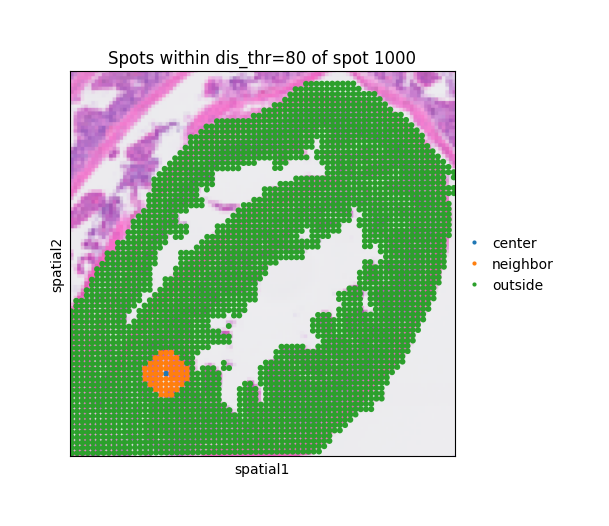

In [19]:
dis_thr = 80
mc.pl.plot_dis_thr(adata = adata, dis_thr = 80, spot_index = 1000)

The function mc.pp.compute_costDistance() calculates the spatial cost distance matrix between all spots, integrating both Euclidean proximity and long-range channel (LRC) effects. Specifically, it adjusts the pairwise distances according to the defined `LRC_type` and their corresponding `LRC_strength`, allowing metabolite diffusion or communication along designated LRC paths to be modeled more realistically. 

The parameters `LRC_type` and `LRC_source` should correspond to the names used in adata.obs['LRC_<LRC_type>_<LRC_source>_filtered'].
A higher value of `LRC_strength` indicates a stronger influence of long-range communication, effectively expanding the propagation range through LRCs. The parameter `dis_thr` should match the distance threshold defined in the previous step.
We support and recommend setting `use_parallel = True` and increasing `n_jobs` within the limits of your system performance, as this can significantly accelerate the computation of the cost distance matrix. The resulting distance matrix is stored in adata.obsp (e.g., adata.obsp['spatial_distance_LRC_Blood']) and can be used in downstream analyses of metabolic cell communication.

In [20]:
mc.pp.compute_costDistance(
    adata = adata,
    LRC_type = ['Blood'],
    LRC_strength = [5],
    LRC_source = "marker",
    dis_thr = dis_thr,
    k_neighb = 5,
    barrier = True,
    barrier_segments = barrier_segs, # consider barrier condition.
    use_parallel = True,
    n_jobs = 64
)

Computing baseline spatial distance without LRC.
  Barrier condition is considered


  Building visible graph with paralleling 64 CPU cores...: 100%|██████████| 5325216/5325216 [00:11<00:00, 476976.14it/s]
  Computing shortest paths for non-visible points: 100%|██████████| 3952490/3952490 [05:29<00:00, 12004.83it/s]


Computing spatial distance with LRCs.
  Processing LRC type: Blood
    Constructing graph for each LRC subcluster.
    Computing shortest path between two points in Blood.
      For the cluster 1 in Blood.


100%|██████████| 1259/1259 [00:23<00:00, 54.01it/s]


    Incorporating LRC strength of 'Blood' into cost distance matrix (strength = 5).
adata.obsp['spatial_distance_LRC_Blood'] has been saved.
Finished!


In [23]:
adata

AnnData object with n_obs × n_vars = 3264 × 19488
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region', 'Cluster', 'barrier_shapes', 'barrier', 'LRC_Blood_avg_markers', 'LRC_Blood_marker_unfiltered', 'LRC_Blood_marker_filtered', 'visualize_LRC_marker', 'LRC_Blood_closepoint_cluster1'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Cluster_colors', 'LRC_Blood_marker_unfiltered_colors', 'barrier_shapes', 'log1p', 'spatial', 'spatialdata_attrs', 'LRC_Blood_marker_filtered_colors', 'visualize_LRC_marker_colors', 'non_visible_pair'
    obsm: 'spatial'
    obsp: 'graph_visible', 'graph_visible_kneighb_5', 'spatial_distance_LRC_base', 'LRC_shortest_Blood_dist80_cluster1', 'spatial_distance_LRC_Blood'

In [24]:
mc.tl.metabolic_communication(adata = adata,
                              database_name = 'MetaChatDB',
                              df_metasen = df_metasen,
                              LRC_type = ["Blood"],
                              dis_thr = 80)

There are 802 pairs were found from the spatial data.


In [ ]:
adata.write('datasets/mouse_small_intestine/metachat_result.h5ad')